# LAB8 tutorial for Machine Learning <br/> Convolutional Neural Network
> 11912911 张子越

## LAB Assignment
### Exercise 1  Image Classifier(100 points )
Follow the above instructions of Image Classifier Training with PyTorch to train your own image classifier (using the [CIFAR10 dataset](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). 

Please try to improve performance of classification by trying different network structures (add layers, modify parameters and so on) and different training strategies (loss function, optimizer and so on). 

<font color='red' size=5>Note: Your accuracy in this exercise will directly determine your score.</font>

In [1]:
# cite: implemented in https://github.com/uoguelph-mlrg/Cutout
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
class Cutout(object):
    """
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
        	# (x,y)表示方形补丁的中心位置
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import datasets, transforms

torch.multiprocessing.set_sharing_strategy('file_system')

import warnings
warnings.filterwarnings("ignore") 

%matplotlib inline

n_epochs = 30
batch_size = 256
train_valid_split = 0.8
learning_rate = 0.1
random_seed = 1
num_workers = 0

torch.manual_seed(random_seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    Cutout(n_holes=1, length=16)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

trainlen = len(trainset)
indices = list(range(trainlen))
np.random.shuffle(indices)
split = int(train_valid_split * trainlen)
trainsampler = SubsetRandomSampler(indices[:split])
validsampler = SubsetRandomSampler(indices[split:])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=trainsampler, num_workers=num_workers)

validloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=validsampler, num_workers=num_workers)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

len(trainloader), len(validloader), len(testloader)

Files already downloaded and verified
Files already downloaded and verified


(157, 40, 40)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


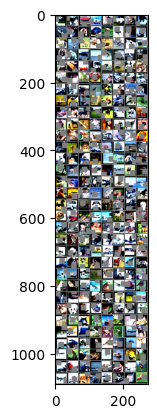

horse cat   car   car   frog  car   frog  deer  ship  bird  horse car   deer  plane dog   deer  horse plane deer  cat   frog  bird  ship  ship  dog   dog   ship  ship  frog  dog   bird  deer  horse truck ship  truck deer  deer  horse horse car   dog   frog  car   cat   car   truck car   plane dog   truck bird  bird  deer  plane cat   plane car   cat   dog   dog   car   frog  deer  car   dog   horse bird  deer  ship  dog   frog  horse horse plane frog  dog   horse horse bird  frog  cat   frog  deer  car   cat   plane frog  cat   bird  frog  car   dog   ship  bird  dog   cat   cat   dog   deer  plane horse dog   frog  frog  deer  dog   car   cat   plane bird  bird  deer  car   dog   frog  plane bird  ship  plane cat   car   cat   plane frog  deer  car   horse horse car   deer  car   deer  frog  truck dog   frog  truck frog  ship  plane horse horse frog  truck deer  deer  dog   dog   car   truck deer  deer  frog  frog  cat   bird  bird  ship  car   plane dog   cat   ship  car   cat   truc

In [3]:
import torchvision

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

#### ResNet18

reference:
- https://zhuanlan.zhihu.com/p/515734064
- https://github.com/ZOMIN28/ResNet18_Cifar10_95.46

##### Network

In [14]:
import torch
from torch import nn


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """
    3x3 convolution with padding
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False,
                     dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """
    1x1 convolution
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, down_sample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError('Dilation > 1 not implemented in BasicBlock')
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.down_sample = down_sample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.down_sample is not None:
            identity = self.down_sample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block,  64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                # if isinstance(m, Bottleneck):
                #     nn.init.constant_(m.bn3.weight, 0)
                # elif isinstance(m, BasicBlock):
                #     nn.init.constant_(m.bn2.weight, 0)
                if isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        down_sample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            down_sample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = [block(self.inplanes, planes, stride, down_sample, self.groups,
                        self.base_width, previous_dilation, norm_layer)]
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))
        return nn.Sequential(*layers)


def _resnet(block, layers, **kwargs):
    model = ResNet(block, layers, **kwargs)
    return model


def ResNet18(**kwargs):
    return _resnet(BasicBlock, [2, 2, 2, 2], **kwargs)

##### Training

In [15]:
import torch
from torch import nn
from torch import optim
from tqdm import tqdm

#存储训练过程
history = {'Train Loss':[],'Valid Loss':[],'Valid Accuracy':[]}

n_epochs = 250
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ResNet18()
model.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
model.fc = nn.Linear(512, len(classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss().to(device)


lr = 0.1

for epoch in range(1, n_epochs+1):
    processBar = tqdm(trainloader, unit='step')

    if epoch % 10 == 0:
        lr *= 0.8
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

    train_loss_total = 0.0

    model.train()
    for step, (inputs, labels) in enumerate(processBar):

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs).to(device)

        loss = criterion(outputs, labels)

        predictions = torch.argmax(outputs, dim=1)
        correct_num = torch.sum(predictions.eq(labels.data.view_as(predictions)))
        accuracy = correct_num / labels.shape[0]

        loss.backward()
        optimizer.step()

        processBar.set_description(f'[{epoch}/{n_epochs}] Loss: {loss.item():.4f}, Acc: {accuracy.item():.4f}')

        train_loss_total += loss

    processBar.close()

    ##########
    # validate model after training an epoch
    ##########
    correct_num_total = 0
    size_total = 0
    valid_loss_total = 0.0

    model.eval()
    with torch.no_grad():
        for (inputs, labels) in validloader:
            inputs = inputs.to(device)
            # print('valid',inputs.shape)
            labels = labels.to(device)

            outputs = model(inputs).to(device)

            loss = criterion(outputs, labels)

            predictions = torch.argmax(outputs, 1)
            correct_num = torch.sum(torch.eq(predictions, labels.data.view_as(predictions)))
            correct_num_total += correct_num

            size_total += labels.shape[0]
            valid_loss_total += loss

    valid_accuracy = correct_num_total / size_total
    valid_loss_avg = valid_loss_total / len(validloader)
    train_loss_avg = train_loss_total / len(trainloader)

    history['Train Loss'].append(train_loss_avg.item())
    history['Valid Loss'] .append(valid_loss_avg. item())
    history['Valid Accuracy'].append(valid_accuracy.item())

    print(f'[{epoch:d}/{n_epochs:d}] Valid Loss: {valid_loss_avg.item():.4f} Valid Acc: {valid_accuracy.item():.4f}')

[1/250] Loss: 2.3064, Acc: 0.2188: 100%|██████████| 157/157 [00:38<00:00,  4.06step/s]


[1/250] Valid Loss: 2.1646 Valid Acc: 0.1932


[2/250] Loss: 1.8199, Acc: 0.3125: 100%|██████████| 157/157 [00:37<00:00,  4.22step/s]


[2/250] Valid Loss: 1.8454 Valid Acc: 0.2885


[3/250] Loss: 1.6656, Acc: 0.3438: 100%|██████████| 157/157 [00:37<00:00,  4.17step/s]


[3/250] Valid Loss: 1.7482 Valid Acc: 0.3594


[4/250] Loss: 1.1985, Acc: 0.5469: 100%|██████████| 157/157 [00:37<00:00,  4.23step/s]


[4/250] Valid Loss: 1.5249 Valid Acc: 0.4382


[5/250] Loss: 1.7225, Acc: 0.3438: 100%|██████████| 157/157 [00:37<00:00,  4.16step/s]


[5/250] Valid Loss: 1.7460 Valid Acc: 0.3789


[6/250] Loss: 0.9810, Acc: 0.6562: 100%|██████████| 157/157 [00:37<00:00,  4.17step/s]


[6/250] Valid Loss: 1.2983 Valid Acc: 0.5345


[7/250] Loss: 1.1996, Acc: 0.5781: 100%|██████████| 157/157 [00:37<00:00,  4.18step/s]


[7/250] Valid Loss: 1.2970 Valid Acc: 0.5432


[8/250] Loss: 1.1174, Acc: 0.5938: 100%|██████████| 157/157 [00:38<00:00,  4.11step/s]


[8/250] Valid Loss: 1.2325 Valid Acc: 0.5697


[9/250] Loss: 1.0236, Acc: 0.5781: 100%|██████████| 157/157 [00:39<00:00,  3.96step/s]


[9/250] Valid Loss: 1.1341 Valid Acc: 0.6039


[10/250] Loss: 0.9005, Acc: 0.6406: 100%|██████████| 157/157 [00:37<00:00,  4.15step/s]


[10/250] Valid Loss: 0.9505 Valid Acc: 0.6682


[11/250] Loss: 0.7566, Acc: 0.7188: 100%|██████████| 157/157 [00:37<00:00,  4.21step/s]


[11/250] Valid Loss: 0.9253 Valid Acc: 0.6695


[12/250] Loss: 0.7742, Acc: 0.7344: 100%|██████████| 157/157 [00:38<00:00,  4.13step/s]


[12/250] Valid Loss: 0.8075 Valid Acc: 0.7164


[13/250] Loss: 0.7597, Acc: 0.8125: 100%|██████████| 157/157 [00:37<00:00,  4.20step/s]


[13/250] Valid Loss: 0.8567 Valid Acc: 0.7047


[14/250] Loss: 0.6514, Acc: 0.7969: 100%|██████████| 157/157 [00:37<00:00,  4.17step/s]


[14/250] Valid Loss: 0.9229 Valid Acc: 0.6834


[15/250] Loss: 0.7292, Acc: 0.7812: 100%|██████████| 157/157 [00:37<00:00,  4.17step/s]


[15/250] Valid Loss: 0.7268 Valid Acc: 0.7466


[16/250] Loss: 0.8712, Acc: 0.6875: 100%|██████████| 157/157 [00:37<00:00,  4.22step/s]


[16/250] Valid Loss: 0.8594 Valid Acc: 0.7001


[17/250] Loss: 0.4747, Acc: 0.8438: 100%|██████████| 157/157 [00:38<00:00,  4.11step/s]


[17/250] Valid Loss: 0.8355 Valid Acc: 0.7053


[18/250] Loss: 0.7283, Acc: 0.7344: 100%|██████████| 157/157 [00:37<00:00,  4.18step/s]


[18/250] Valid Loss: 0.8096 Valid Acc: 0.7193


[19/250] Loss: 0.4656, Acc: 0.8281: 100%|██████████| 157/157 [00:38<00:00,  4.11step/s]


[19/250] Valid Loss: 0.7264 Valid Acc: 0.7453


[20/250] Loss: 0.4276, Acc: 0.8281: 100%|██████████| 157/157 [00:37<00:00,  4.21step/s]


[20/250] Valid Loss: 0.7370 Valid Acc: 0.7518


[21/250] Loss: 0.4905, Acc: 0.8281: 100%|██████████| 157/157 [00:37<00:00,  4.18step/s]


[21/250] Valid Loss: 0.6398 Valid Acc: 0.7803


[22/250] Loss: 0.4303, Acc: 0.8594: 100%|██████████| 157/157 [00:38<00:00,  4.11step/s]


[22/250] Valid Loss: 0.6575 Valid Acc: 0.7773


[23/250] Loss: 0.5821, Acc: 0.7656: 100%|██████████| 157/157 [00:37<00:00,  4.21step/s]


[23/250] Valid Loss: 0.6418 Valid Acc: 0.7867


[24/250] Loss: 0.5409, Acc: 0.7812: 100%|██████████| 157/157 [00:37<00:00,  4.19step/s]


[24/250] Valid Loss: 0.6728 Valid Acc: 0.7760


[25/250] Loss: 0.5009, Acc: 0.7969: 100%|██████████| 157/157 [00:37<00:00,  4.20step/s]


[25/250] Valid Loss: 0.5631 Valid Acc: 0.8070


[26/250] Loss: 0.5001, Acc: 0.7969: 100%|██████████| 157/157 [00:37<00:00,  4.19step/s]


[26/250] Valid Loss: 0.6818 Valid Acc: 0.7693


[27/250] Loss: 0.6620, Acc: 0.8125: 100%|██████████| 157/157 [00:37<00:00,  4.20step/s]


[27/250] Valid Loss: 0.6410 Valid Acc: 0.7774


[28/250] Loss: 0.4036, Acc: 0.8594: 100%|██████████| 157/157 [00:38<00:00,  4.07step/s]


[28/250] Valid Loss: 0.5481 Valid Acc: 0.8163


[29/250] Loss: 0.4752, Acc: 0.8594: 100%|██████████| 157/157 [00:37<00:00,  4.18step/s]


[29/250] Valid Loss: 0.6729 Valid Acc: 0.7729


[30/250] Loss: 0.3173, Acc: 0.8750: 100%|██████████| 157/157 [00:38<00:00,  4.12step/s]


[30/250] Valid Loss: 0.5242 Valid Acc: 0.8204


[31/250] Loss: 0.4497, Acc: 0.8438: 100%|██████████| 157/157 [00:38<00:00,  4.07step/s]


[31/250] Valid Loss: 0.4742 Valid Acc: 0.8356


[32/250] Loss: 0.2937, Acc: 0.9062: 100%|██████████| 157/157 [00:38<00:00,  4.11step/s]


[32/250] Valid Loss: 0.4972 Valid Acc: 0.8274


[33/250] Loss: 0.2994, Acc: 0.8906: 100%|██████████| 157/157 [00:37<00:00,  4.19step/s]


[33/250] Valid Loss: 0.4787 Valid Acc: 0.8307


[34/250] Loss: 0.2185, Acc: 0.9219: 100%|██████████| 157/157 [00:38<00:00,  4.11step/s]


[34/250] Valid Loss: 0.4929 Valid Acc: 0.8337


[35/250] Loss: 0.4216, Acc: 0.8594: 100%|██████████| 157/157 [00:37<00:00,  4.20step/s]


[35/250] Valid Loss: 0.5256 Valid Acc: 0.8257


[36/250] Loss: 0.3968, Acc: 0.8750: 100%|██████████| 157/157 [00:37<00:00,  4.19step/s]


[36/250] Valid Loss: 0.6311 Valid Acc: 0.7940


[37/250] Loss: 0.3337, Acc: 0.8750: 100%|██████████| 157/157 [00:38<00:00,  4.09step/s]


[37/250] Valid Loss: 0.6371 Valid Acc: 0.7917


[38/250] Loss: 0.5247, Acc: 0.8438: 100%|██████████| 157/157 [00:37<00:00,  4.16step/s]


[38/250] Valid Loss: 0.5148 Valid Acc: 0.8217


[39/250] Loss: 0.2856, Acc: 0.9375: 100%|██████████| 157/157 [00:37<00:00,  4.18step/s]


[39/250] Valid Loss: 0.5103 Valid Acc: 0.8262


[40/250] Loss: 0.2292, Acc: 0.9375: 100%|██████████| 157/157 [00:38<00:00,  4.12step/s]


[40/250] Valid Loss: 0.4487 Valid Acc: 0.8467


[41/250] Loss: 0.3659, Acc: 0.8438: 100%|██████████| 157/157 [00:39<00:00,  3.96step/s]


[41/250] Valid Loss: 0.4457 Valid Acc: 0.8526


[42/250] Loss: 0.3130, Acc: 0.9062: 100%|██████████| 157/157 [00:37<00:00,  4.19step/s]


[42/250] Valid Loss: 0.5188 Valid Acc: 0.8253


[43/250] Loss: 0.3309, Acc: 0.8906: 100%|██████████| 157/157 [00:37<00:00,  4.19step/s]


[43/250] Valid Loss: 0.5113 Valid Acc: 0.8285


[44/250] Loss: 0.3184, Acc: 0.9219: 100%|██████████| 157/157 [00:38<00:00,  4.03step/s]


[44/250] Valid Loss: 0.4890 Valid Acc: 0.8356


[45/250] Loss: 0.2189, Acc: 0.9219: 100%|██████████| 157/157 [00:37<00:00,  4.22step/s]


[45/250] Valid Loss: 0.4937 Valid Acc: 0.8325


[46/250] Loss: 0.4995, Acc: 0.7969: 100%|██████████| 157/157 [00:39<00:00,  4.00step/s]


[46/250] Valid Loss: 0.5333 Valid Acc: 0.8251


[47/250] Loss: 0.3255, Acc: 0.8906: 100%|██████████| 157/157 [00:37<00:00,  4.18step/s]


[47/250] Valid Loss: 0.5046 Valid Acc: 0.8378


[48/250] Loss: 0.2186, Acc: 0.8906: 100%|██████████| 157/157 [00:38<00:00,  4.13step/s]


[48/250] Valid Loss: 0.5237 Valid Acc: 0.8309


[49/250] Loss: 0.2814, Acc: 0.8750: 100%|██████████| 157/157 [00:39<00:00,  3.95step/s]


[49/250] Valid Loss: 0.4506 Valid Acc: 0.8474


[50/250] Loss: 0.3907, Acc: 0.8594: 100%|██████████| 157/157 [00:38<00:00,  4.05step/s]


[50/250] Valid Loss: 0.4272 Valid Acc: 0.8593


[51/250] Loss: 0.2754, Acc: 0.9219: 100%|██████████| 157/157 [00:38<00:00,  4.13step/s]


[51/250] Valid Loss: 0.4355 Valid Acc: 0.8549


[52/250] Loss: 0.2698, Acc: 0.8750: 100%|██████████| 157/157 [00:37<00:00,  4.14step/s]


[52/250] Valid Loss: 0.4601 Valid Acc: 0.8496


[53/250] Loss: 0.3361, Acc: 0.8594: 100%|██████████| 157/157 [00:37<00:00,  4.19step/s]


[53/250] Valid Loss: 0.4282 Valid Acc: 0.8571


[54/250] Loss: 0.4821, Acc: 0.8594: 100%|██████████| 157/157 [00:37<00:00,  4.20step/s]


[54/250] Valid Loss: 0.4362 Valid Acc: 0.8537


[55/250] Loss: 0.3476, Acc: 0.9062: 100%|██████████| 157/157 [00:37<00:00,  4.18step/s]


[55/250] Valid Loss: 0.4585 Valid Acc: 0.8512


[56/250] Loss: 0.0894, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.19step/s]


[56/250] Valid Loss: 0.5270 Valid Acc: 0.8294


[57/250] Loss: 0.3809, Acc: 0.8906: 100%|██████████| 157/157 [00:38<00:00,  4.08step/s]


[57/250] Valid Loss: 0.4441 Valid Acc: 0.8558


[58/250] Loss: 0.0813, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.17step/s]


[58/250] Valid Loss: 0.4673 Valid Acc: 0.8474


[59/250] Loss: 0.3001, Acc: 0.8594: 100%|██████████| 157/157 [00:37<00:00,  4.17step/s]


[59/250] Valid Loss: 0.4757 Valid Acc: 0.8452


[63/250] Loss: 0.3451, Acc: 0.8906: 100%|██████████| 157/157 [00:39<00:00,  3.99step/s]


[63/250] Valid Loss: 0.4240 Valid Acc: 0.8594


[64/250] Loss: 0.1881, Acc: 0.9531: 100%|██████████| 157/157 [00:38<00:00,  4.10step/s]


[64/250] Valid Loss: 0.3907 Valid Acc: 0.8692


[65/250] Loss: 0.1209, Acc: 0.9688: 100%|██████████| 157/157 [00:37<00:00,  4.23step/s]


[65/250] Valid Loss: 0.4337 Valid Acc: 0.8598


[66/250] Loss: 0.1918, Acc: 0.9375: 100%|██████████| 157/157 [00:37<00:00,  4.21step/s]


[66/250] Valid Loss: 0.4190 Valid Acc: 0.8665


[67/250] Loss: 0.1989, Acc: 0.9531: 100%|██████████| 157/157 [00:37<00:00,  4.19step/s]


[67/250] Valid Loss: 0.4393 Valid Acc: 0.8612


[68/250] Loss: 0.4413, Acc: 0.8594: 100%|██████████| 157/157 [00:37<00:00,  4.21step/s]


[68/250] Valid Loss: 0.4069 Valid Acc: 0.8645


[69/250] Loss: 0.1801, Acc: 0.9375: 100%|██████████| 157/157 [00:37<00:00,  4.19step/s]


[69/250] Valid Loss: 0.3576 Valid Acc: 0.8793


[70/250] Loss: 0.3611, Acc: 0.8906: 100%|██████████| 157/157 [00:37<00:00,  4.19step/s]


[70/250] Valid Loss: 0.4157 Valid Acc: 0.8723


[71/250] Loss: 0.1297, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.18step/s]


[71/250] Valid Loss: 0.3809 Valid Acc: 0.8772


[72/250] Loss: 0.3059, Acc: 0.8906: 100%|██████████| 157/157 [00:37<00:00,  4.18step/s]


[72/250] Valid Loss: 0.4578 Valid Acc: 0.8601


[73/250] Loss: 0.1109, Acc: 0.9570:  11%|█         | 17/157 [00:04<00:33,  4.17step/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

[101/250] Loss: 0.0424, Acc: 1.0000: 100%|██████████| 157/157 [00:38<00:00,  4.12step/s]


[101/250] Valid Loss: 0.3425 Valid Acc: 0.8968


[102/250] Loss: 0.1133, Acc: 0.9531: 100%|██████████| 157/157 [00:37<00:00,  4.19step/s]


[102/250] Valid Loss: 0.3406 Valid Acc: 0.8962


[103/250] Loss: 0.1348, Acc: 0.9531: 100%|██████████| 157/157 [00:37<00:00,  4.16step/s]


[103/250] Valid Loss: 0.3269 Valid Acc: 0.9038


[104/250] Loss: 0.1694, Acc: 0.9062: 100%|██████████| 157/157 [00:38<00:00,  4.04step/s]


[104/250] Valid Loss: 0.3457 Valid Acc: 0.8955


[105/250] Loss: 0.1159, Acc: 0.9531: 100%|██████████| 157/157 [00:37<00:00,  4.21step/s]


[105/250] Valid Loss: 0.3206 Valid Acc: 0.9009


[106/250] Loss: 0.0355, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.20step/s]


[106/250] Valid Loss: 0.3571 Valid Acc: 0.8922


[107/250] Loss: 0.0818, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.20step/s]


[107/250] Valid Loss: 0.3593 Valid Acc: 0.8905


[108/250] Loss: 0.1136, Acc: 0.9531: 100%|██████████| 157/157 [00:37<00:00,  4.20step/s]


[108/250] Valid Loss: 0.3281 Valid Acc: 0.9010


[109/250] Loss: 0.0638, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.19step/s]


[109/250] Valid Loss: 0.3467 Valid Acc: 0.9002


[110/250] Loss: 0.0666, Acc: 0.9766:  79%|███████▉  | 124/157 [00:29<00:07,  4.17step/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

[136/250] Loss: 0.1213, Acc: 0.9688: 100%|██████████| 157/157 [00:37<00:00,  4.14step/s]


[136/250] Valid Loss: 0.2973 Valid Acc: 0.9108


[137/250] Loss: 0.0780, Acc: 0.9688: 100%|██████████| 157/157 [00:37<00:00,  4.18step/s]


[137/250] Valid Loss: 0.3121 Valid Acc: 0.9065


[138/250] Loss: 0.0252, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.23step/s]


[138/250] Valid Loss: 0.3119 Valid Acc: 0.9136


[139/250] Loss: 0.0377, Acc: 0.9688: 100%|██████████| 157/157 [00:37<00:00,  4.21step/s]


[139/250] Valid Loss: 0.3144 Valid Acc: 0.9098


[140/250] Loss: 0.0097, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.19step/s]


[140/250] Valid Loss: 0.2968 Valid Acc: 0.9134


[141/250] Loss: 0.0350, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.18step/s]


[141/250] Valid Loss: 0.3043 Valid Acc: 0.9152


[142/250] Loss: 0.0958, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.19step/s]


[142/250] Valid Loss: 0.3012 Valid Acc: 0.9135


[143/250] Loss: 0.0662, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.20step/s]


[143/250] Valid Loss: 0.2934 Valid Acc: 0.9168


[144/250] Loss: 0.0081, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.18step/s]


[144/250] Valid Loss: 0.3059 Valid Acc: 0.9099


[145/250] Loss: 0.0209, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.19step/s]


[145/250] Valid Loss: 0.2834 Valid Acc: 0.9136


[146/250] Loss: 0.0466, Acc: 0.9883:   5%|▌         | 8/157 [00:02<00:36,  4.11step/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

[170/250] Loss: 0.0156, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.20step/s]


[170/250] Valid Loss: 0.2989 Valid Acc: 0.9189


[171/250] Loss: 0.0071, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.20step/s]


[171/250] Valid Loss: 0.2918 Valid Acc: 0.9209


[172/250] Loss: 0.0668, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.20step/s]


[172/250] Valid Loss: 0.2981 Valid Acc: 0.9180


[173/250] Loss: 0.0159, Acc: 1.0000: 100%|██████████| 157/157 [00:38<00:00,  4.12step/s]


[173/250] Valid Loss: 0.3055 Valid Acc: 0.9174


[174/250] Loss: 0.0814, Acc: 0.9531: 100%|██████████| 157/157 [00:37<00:00,  4.21step/s]


[174/250] Valid Loss: 0.2996 Valid Acc: 0.9193


[175/250] Loss: 0.1156, Acc: 0.9688: 100%|██████████| 157/157 [00:37<00:00,  4.21step/s]


[175/250] Valid Loss: 0.3048 Valid Acc: 0.9172


[176/250] Loss: 0.0142, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.20step/s]


[176/250] Valid Loss: 0.2992 Valid Acc: 0.9131


[177/250] Loss: 0.0254, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.17step/s]


[177/250] Valid Loss: 0.2971 Valid Acc: 0.9209


[178/250] Loss: 0.0281, Acc: 0.9844: 100%|██████████| 157/157 [00:38<00:00,  4.12step/s]


[178/250] Valid Loss: 0.2877 Valid Acc: 0.9200


[179/250] Loss: 0.0232, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.18step/s]


[179/250] Valid Loss: 0.3019 Valid Acc: 0.9154


[180/250] Loss: 0.0101, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.18step/s]


[180/250] Valid Loss: 0.2924 Valid Acc: 0.9191


[181/250] Loss: 0.0540, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.17step/s]


[181/250] Valid Loss: 0.2881 Valid Acc: 0.9216


[182/250] Loss: 0.0015, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.19step/s]


[182/250] Valid Loss: 0.2915 Valid Acc: 0.9187


[183/250] Loss: 0.0078, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.17step/s]


[183/250] Valid Loss: 0.2954 Valid Acc: 0.9181


[184/250] Loss: 0.0400, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.18step/s]


[184/250] Valid Loss: 0.2899 Valid Acc: 0.9184


[185/250] Loss: 0.0139, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.18step/s]


[185/250] Valid Loss: 0.3010 Valid Acc: 0.9186


[186/250] Loss: 0.0103, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.19step/s]


[186/250] Valid Loss: 0.2930 Valid Acc: 0.9223


[187/250] Loss: 0.0123, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.21step/s]


[187/250] Valid Loss: 0.2801 Valid Acc: 0.9203


[188/250] Loss: 0.0422, Acc: 0.9688: 100%|██████████| 157/157 [00:37<00:00,  4.18step/s]


[188/250] Valid Loss: 0.2835 Valid Acc: 0.9195


[189/250] Loss: 0.0063, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.21step/s]


[189/250] Valid Loss: 0.2842 Valid Acc: 0.9199


[190/250] Loss: 0.0089, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.18step/s]


[190/250] Valid Loss: 0.2974 Valid Acc: 0.9179


[191/250] Loss: 0.0200, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.24step/s]


[191/250] Valid Loss: 0.2734 Valid Acc: 0.9233


[192/250] Loss: 0.0321, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.22step/s]


[192/250] Valid Loss: 0.2884 Valid Acc: 0.9197


[193/250] Loss: 0.0072, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.21step/s]


[193/250] Valid Loss: 0.2848 Valid Acc: 0.9193


[194/250] Loss: 0.0081, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.22step/s]


[194/250] Valid Loss: 0.2881 Valid Acc: 0.9215


[195/250] Loss: 0.0192, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.21step/s]


[195/250] Valid Loss: 0.2717 Valid Acc: 0.9229


[196/250] Loss: 0.0343, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.20step/s]


[196/250] Valid Loss: 0.2977 Valid Acc: 0.9193


[197/250] Loss: 0.0057, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.17step/s]


[197/250] Valid Loss: 0.2783 Valid Acc: 0.9229


[198/250] Loss: 0.0034, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.19step/s]


[198/250] Valid Loss: 0.3043 Valid Acc: 0.9181


[199/250] Loss: 0.0681, Acc: 0.9688: 100%|██████████| 157/157 [00:37<00:00,  4.17step/s]


[199/250] Valid Loss: 0.2665 Valid Acc: 0.9247


[200/250] Loss: 0.0057, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.19step/s]


[200/250] Valid Loss: 0.2844 Valid Acc: 0.9242


[201/250] Loss: 0.0324, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.14step/s]


[201/250] Valid Loss: 0.2995 Valid Acc: 0.9205


[202/250] Loss: 0.0125, Acc: 1.0000: 100%|██████████| 157/157 [00:39<00:00,  4.02step/s]


[202/250] Valid Loss: 0.2732 Valid Acc: 0.9247


[203/250] Loss: 0.0282, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.21step/s]


[203/250] Valid Loss: 0.2858 Valid Acc: 0.9184


[204/250] Loss: 0.0478, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.19step/s]


[204/250] Valid Loss: 0.2669 Valid Acc: 0.9226


[205/250] Loss: 0.0023, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.21step/s]


[205/250] Valid Loss: 0.2706 Valid Acc: 0.9220


[206/250] Loss: 0.0204, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.17step/s]


[206/250] Valid Loss: 0.3006 Valid Acc: 0.9215


[207/250] Loss: 0.0274, Acc: 1.0000: 100%|██████████| 157/157 [00:38<00:00,  4.09step/s]


[207/250] Valid Loss: 0.2876 Valid Acc: 0.9228


[208/250] Loss: 0.0405, Acc: 0.9688: 100%|██████████| 157/157 [00:37<00:00,  4.20step/s]


[208/250] Valid Loss: 0.2862 Valid Acc: 0.9211


[209/250] Loss: 0.0089, Acc: 1.0000: 100%|██████████| 157/157 [00:38<00:00,  4.13step/s]


[209/250] Valid Loss: 0.2719 Valid Acc: 0.9229


[210/250] Loss: 0.1043, Acc: 0.9531: 100%|██████████| 157/157 [00:37<00:00,  4.20step/s]


[210/250] Valid Loss: 0.2713 Valid Acc: 0.9240


[211/250] Loss: 0.0580, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.15step/s]


[211/250] Valid Loss: 0.2791 Valid Acc: 0.9219


[212/250] Loss: 0.0574, Acc: 0.9844: 100%|██████████| 157/157 [00:39<00:00,  3.97step/s]


[212/250] Valid Loss: 0.2960 Valid Acc: 0.9221


[213/250] Loss: 0.0117, Acc: 1.0000: 100%|██████████| 157/157 [00:36<00:00,  4.25step/s]


[213/250] Valid Loss: 0.2890 Valid Acc: 0.9211


[214/250] Loss: 0.0062, Acc: 1.0000: 100%|██████████| 157/157 [00:36<00:00,  4.25step/s]


[214/250] Valid Loss: 0.2829 Valid Acc: 0.9215


[215/250] Loss: 0.0043, Acc: 1.0000: 100%|██████████| 157/157 [00:36<00:00,  4.26step/s]


[215/250] Valid Loss: 0.2831 Valid Acc: 0.9259


[216/250] Loss: 0.0016, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.20step/s]


[216/250] Valid Loss: 0.2965 Valid Acc: 0.9226


[217/250] Loss: 0.0034, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.21step/s]


[217/250] Valid Loss: 0.2615 Valid Acc: 0.9268


[218/250] Loss: 0.0052, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.20step/s]


[218/250] Valid Loss: 0.2780 Valid Acc: 0.9214


[219/250] Loss: 0.0075, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.14step/s]


[219/250] Valid Loss: 0.2658 Valid Acc: 0.9252


[220/250] Loss: 0.0021, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.19step/s]


[220/250] Valid Loss: 0.2981 Valid Acc: 0.9203


[221/250] Loss: 0.0467, Acc: 0.9844: 100%|██████████| 157/157 [00:38<00:00,  4.09step/s]


[221/250] Valid Loss: 0.2917 Valid Acc: 0.9232


[222/250] Loss: 0.0228, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.21step/s]


[222/250] Valid Loss: 0.2795 Valid Acc: 0.9234


[223/250] Loss: 0.0191, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.24step/s]


[223/250] Valid Loss: 0.2885 Valid Acc: 0.9209


[224/250] Loss: 0.0080, Acc: 1.0000: 100%|██████████| 157/157 [00:36<00:00,  4.26step/s]


[224/250] Valid Loss: 0.2752 Valid Acc: 0.9243


[225/250] Loss: 0.1119, Acc: 0.9688: 100%|██████████| 157/157 [00:37<00:00,  4.22step/s]


[225/250] Valid Loss: 0.2975 Valid Acc: 0.9188


[226/250] Loss: 0.0090, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.21step/s]


[226/250] Valid Loss: 0.2655 Valid Acc: 0.9238


[227/250] Loss: 0.0363, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.21step/s]


[227/250] Valid Loss: 0.2819 Valid Acc: 0.9224


[228/250] Loss: 0.0444, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.19step/s]


[228/250] Valid Loss: 0.2806 Valid Acc: 0.9251


[229/250] Loss: 0.0114, Acc: 1.0000: 100%|██████████| 157/157 [00:38<00:00,  4.10step/s]


[229/250] Valid Loss: 0.2867 Valid Acc: 0.9230


[230/250] Loss: 0.0025, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.18step/s]


[230/250] Valid Loss: 0.2924 Valid Acc: 0.9210


[231/250] Loss: 0.0074, Acc: 1.0000: 100%|██████████| 157/157 [00:38<00:00,  4.12step/s]


[231/250] Valid Loss: 0.2867 Valid Acc: 0.9210


[232/250] Loss: 0.0281, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.18step/s]


[232/250] Valid Loss: 0.2809 Valid Acc: 0.9243


[233/250] Loss: 0.0036, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.23step/s]


[233/250] Valid Loss: 0.2708 Valid Acc: 0.9234


[234/250] Loss: 0.0067, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.19step/s]


[234/250] Valid Loss: 0.2855 Valid Acc: 0.9218


[235/250] Loss: 0.0028, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.16step/s]


[235/250] Valid Loss: 0.2765 Valid Acc: 0.9227


[236/250] Loss: 0.0089, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.18step/s]


[236/250] Valid Loss: 0.2719 Valid Acc: 0.9232


[237/250] Loss: 0.0355, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.19step/s]


[237/250] Valid Loss: 0.2657 Valid Acc: 0.9265


[238/250] Loss: 0.0460, Acc: 0.9688: 100%|██████████| 157/157 [00:37<00:00,  4.24step/s]


[238/250] Valid Loss: 0.2665 Valid Acc: 0.9230


[239/250] Loss: 0.0436, Acc: 0.9688: 100%|██████████| 157/157 [00:37<00:00,  4.22step/s]


[239/250] Valid Loss: 0.2823 Valid Acc: 0.9231


[240/250] Loss: 0.0067, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.24step/s]


[240/250] Valid Loss: 0.2816 Valid Acc: 0.9230


[241/250] Loss: 0.0266, Acc: 0.9844: 100%|██████████| 157/157 [00:38<00:00,  4.12step/s]


[241/250] Valid Loss: 0.2746 Valid Acc: 0.9246


[242/250] Loss: 0.0404, Acc: 0.9844: 100%|██████████| 157/157 [00:39<00:00,  4.01step/s]


[242/250] Valid Loss: 0.3066 Valid Acc: 0.9239


[243/250] Loss: 0.0115, Acc: 1.0000: 100%|██████████| 157/157 [00:39<00:00,  3.99step/s]


[243/250] Valid Loss: 0.2930 Valid Acc: 0.9223


[244/250] Loss: 0.0057, Acc: 1.0000: 100%|██████████| 157/157 [00:38<00:00,  4.10step/s]


[244/250] Valid Loss: 0.2805 Valid Acc: 0.9245


[245/250] Loss: 0.0587, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.20step/s]


[245/250] Valid Loss: 0.2823 Valid Acc: 0.9242


[246/250] Loss: 0.0601, Acc: 0.9688: 100%|██████████| 157/157 [00:38<00:00,  4.11step/s]


[246/250] Valid Loss: 0.2841 Valid Acc: 0.9236


[247/250] Loss: 0.0468, Acc: 0.9844: 100%|██████████| 157/157 [00:38<00:00,  4.12step/s]


[247/250] Valid Loss: 0.2848 Valid Acc: 0.9241


[248/250] Loss: 0.0135, Acc: 1.0000: 100%|██████████| 157/157 [00:38<00:00,  4.11step/s]


[248/250] Valid Loss: 0.2750 Valid Acc: 0.9233


[249/250] Loss: 0.0187, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.22step/s]


[249/250] Valid Loss: 0.2851 Valid Acc: 0.9237


[250/250] Loss: 0.0064, Acc: 1.0000: 100%|██████████| 157/157 [00:38<00:00,  4.07step/s]


[250/250] Valid Loss: 0.2815 Valid Acc: 0.9207


##### Testing

In [16]:
correct_num_total = 0
size_total = 0
test_loss_total = 0.0

model.eval()
with torch.no_grad():
    for (inputs, labels) in testloader:
        inputs = inputs.to(device)
        # print('test',inputs.shape)
        labels = labels.to(device)

        outputs = model(inputs).to(device)

        loss = criterion(outputs, labels)

        predictions = torch.argmax(outputs, 1)
        correct_num = torch.sum(torch.eq(predictions, labels.data.view_as(predictions)))
        correct_num_total += correct_num

        size_total += labels.shape[0]
        test_loss_total += loss

test_accuracy = correct_num_total / size_total
test_loss_avg = test_loss_total / len(testloader)

print(f'Test Loss: {test_loss_avg.item():.4f} Test Acc: {test_accuracy.item():.4f}')

Test Loss: 0.1877 Test Acc: 0.9528


In [17]:
# save the model
PATH = 'cifar10_best.pth'

print(model)
torch.save(model.state_dict(), PATH)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

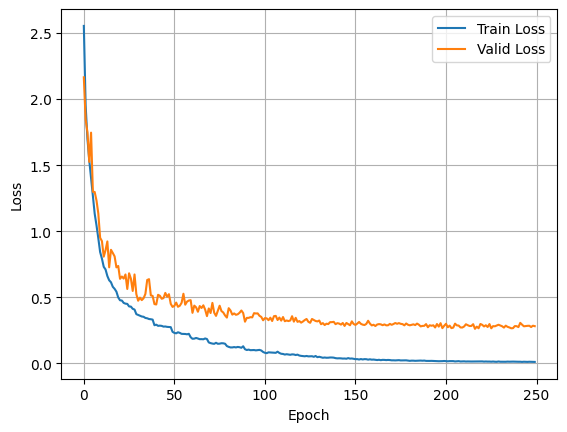

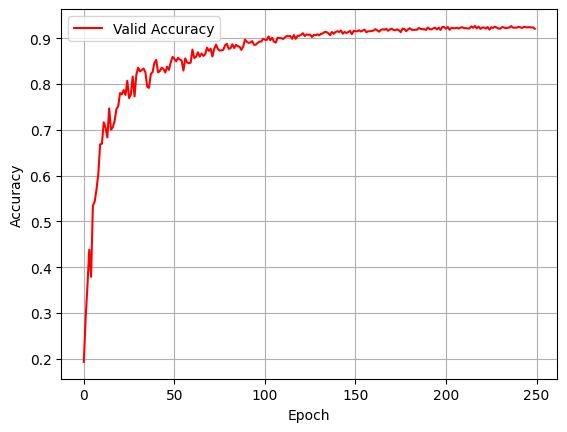

In [18]:
#对测试Loss进行可视化
plt.plot(history['Train Loss'],label = 'Train Loss')
plt.plot(history['Valid Loss'],label = 'Valid Loss')
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#对测试准确率进行可视化
plt.plot(history['Valid Accuracy'],color = 'red',label = 'Valid Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

### Exercise 2  Questions (4 points )
1. Can neural networks be used for unsupervised clustering or data dimension reduction? Why?

2. What are the strengths of neural networks; when do they perform well?

3. What are the weaknesses of neural networks; when do they perform poorly?

4. What makes neural networks a good candidate for the classification regression problem, if you have enough knowledge about the data?

Answer:
=======

(1): 

Yes. For example, autoencoder can learn high-dimension input data and output low-dimension data, thus can be used to reduce dimension. The high-dimensional data are first encoded to reduce its dimension, then it uses decoder to recover the original data.

(2):

1.Neural networks can learn enormous data while traditional methods can't.
2.They can map all kinds of relationship while user don't have to choose model or examine the data beforehand.
3.Neural networks have strong learning ability to learn from numerous high-dimensional features.
4.Strong generalization ability.

It performs well when there are sufficient training data.

(3):

1.Neural networks are complicated, the parameters have large space complexity, the training and prediction have large time complexity.
2.Neural networks are hard to understand, so it is hard to improve.
3.Requre large amounts of data.

It performs poorly when the parameters are not good, or the network structure is wrong, or the data contains too many errors, or the dataset is too small.

(4):

1.Neural networks can fit all kinds of relationships.
2.Datasets are easy to construct when we have enough knowledge about the data.

